# <center>Capstone Project<center>
# <center>Finding a Philadelphia Neighborhood Most Similar to Almagro, Madrid<center>

## Introduction

The project objective is to find a neighborhood in Philadelphia, PA, USA, that is most similar to Almagro, Madrid, but the program is applicable for finding a neighborhood in any city that is similar to some other target neighborhood.  The algorithm could be used by people who are planning to move to a new city and want to find a neighborhood that is most similar to a known neighborhood that they find desirable.
The algorithm also incorporates real estate price data so that the user can compare similarity between neighborhoods and median housing prices to find a most optimal match for his/her particular situation.

## Data Sources

### The following data sources will be utilized in the algorithm:  
-GPS data from Nominatim: www.openstreetmap.org  
-The Foursquare Places API for exploring neighborhood venues https://developer.foursquare.com/  
-A list of Philadelphia neighborhoods and housing price statistics published by Philadelphia magazine at https://www.phillymag.com/property/house-prices-philadelphia-suburbs/#philly  

## Methodology

The target neighborhood, Almagro, Madrid will be characterized through an analysis of nearby venues utilizing the Foursquare Places API.  Philadelphia neighborhoods will then be characterized in the same manner, and k-means clustering will be utilized to group Philadelphia neighborhoods by similarity in venue types.  Almagro, Madrid will be included in the clustering analysis to identify the cluster of Philadelphia neighborhoods that is most similar to it.

To further identify the Philadelphia neighborhoods that are most similar to Almagro, exact Euclidian distance from Almagro will be calculated in the multidimensional venue space.  The neighborhoods will then be plotted in a scatter plot against median housing prices to provide an assessment of affordability along with similarity to Almagro.  The ideal neighborhood will be similar to Almagro, but also affordable for the user of the algorithm.

## Analysis, Results and Discussion

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.html import read_html

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment in conda-forge geopy not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Map the Almagro Neighborhood in Madrid

In [2]:
# Set address on which to center map
address = 'Almagro, Madrid, Spain' 

geolocator = Nominatim(user_agent="JMAp")
location = geolocator.geocode(address)
Almagro_lat = location.latitude
Almagro_lon = location.longitude
print('The geograpical coordinate of', address,'are {}, {}.'.format(Almagro_lat, Almagro_lon))

The geograpical coordinate of Almagro, Madrid, Spain are 40.4313814, -3.6930142045414542.


In [3]:
# create map of Madrid using Almagro latitude and longitude values
MADmap = folium.Map(location=[Almagro_lat, Almagro_lon], zoom_start=15)

label = 'Almagro'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [Almagro_lat, Almagro_lon],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        parse_html=False).add_to(MADmap)  
    
MADmap

## Explore target neighborhood - Almagro

In [4]:
# Define Foursquare credentials
import os
CLIENT_ID = os.environ.get('4S_ID') # relpace os.environ.get('4S_ID') with 'Your Foursquare ID'
CLIENT_SECRET = os.environ.get('4S_SECRET') # relpace os.environ.get('4S_SECRET') with 'Your Foursquare SECRET'
VERSION = '20190731' # Foursquare API version

In [5]:
# Define url for exploring venues within 750 meters of Almagro center
radius = 500
LIMIT = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            Almagro_lat, 
            Almagro_lon, 
            radius, 
            LIMIT)

In [6]:
# Query Foursquare API and get results
Almagro_results = requests.get(url).json()
Almagro_results

{'meta': {'code': 200, 'requestId': '5eaec9c7c94979001bf28084'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Almagro',
  'headerFullLocation': 'Almagro, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 120,
  'suggestedBounds': {'ne': {'lat': 40.4358814045, 'lng': -3.687113388018446},
   'sw': {'lat': 40.4268813955, 'lng': -3.6989150210644626}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '59aeaadfaa6c95709b89d9a3',
       'name': 'Fellina',
       'location': {'address': 'Caracas 21',
        'lat': 40.430752,
        'lng': -3.694272,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.430752,
          'lng': -3.694272}],
        '

In [7]:
# Define function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
# Examine json file
print(requests.get(url).json())

{'meta': {'code': 200, 'requestId': '5eaec98db1cac0001b99bcd3'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Almagro', 'headerFullLocation': 'Almagro, Madrid', 'headerLocationGranularity': 'neighborhood', 'totalResults': 120, 'suggestedBounds': {'ne': {'lat': 40.4358814045, 'lng': -3.687113388018446}, 'sw': {'lat': 40.4268813955, 'lng': -3.6989150210644626}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '59aeaadfaa6c95709b89d9a3', 'name': 'Fellina', 'location': {'address': 'Caracas 21', 'lat': 40.430752, 'lng': -3.694272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.430752, 'lng': -3.694272}], 'distance': 127, 'postalCode': '28010', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddre

In [9]:
# Create new dataframe with Almagro venue results
venues = Almagro_results['response']['groups'][0]['items']
    
Almagro_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
Almagro_venues =Almagro_venues.loc[:, filtered_columns]

# filter the category for each row
Almagro_venues['venue.categories'] = Almagro_venues.apply(get_category_type, axis=1)

# clean columns
Almagro_venues.columns = [col.split(".")[-1] for col in Almagro_venues.columns]

In [10]:
# Find number of nearby venues
Almagro_venues.shape

(100, 4)

In [11]:
Almagro_venues

,name,categories,lat,lng
0,Fellina,Italian Restaurant,40.430752,-3.694272
1,"Hotel Santo Mauro, Autograph Collection",Hotel,40.430934,-3.693156
2,Las Tortillas de Gabino,Spanish Restaurant,40.433971,-3.693841
3,Pancomido,Café,40.433888,-3.693107
4,El Mentidero De La Villa,Gastropub,40.429286,-3.693919
5,The Hovse,Market,40.431774,-3.692920
6,Conlaya,Spanish Restaurant,40.428599,-3.693692
7,Pastelería Ascaso,Pie Shop,40.430617,-3.693662
8,Ditirambo,Brewery,40.433777,-3.692126
9,La parra,Spanish Restaurant,40.430069,-3.691871


Text(0, 0.5, 'Frequency')

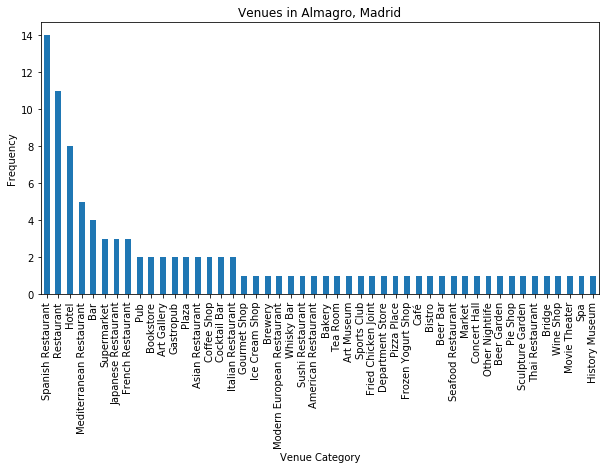

In [12]:
# Plot categories as bar chart
barchart = Almagro_venues['categories'].value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="Venues in Almagro, Madrid")
barchart.set_xlabel("Venue Category")
barchart.set_ylabel("Frequency")

**Observations:** The Almagro neighborhood has a high concentration and wide variety of restaurants.  Spanish and Mediterranean  restaurants are most common.  There are also a good number of bars/pubs and hotels, and some art galleries. 

## Explore Neighborhoods in Philadelphia

In [13]:
# Read data table of Philadelphia neighborhoods and real estate data
page = "https://www.phillymag.com/property/house-prices-philadelphia-suburbs/#philly"

table= read_html(page, index_col=0)#, attrs={"class":"wikitable"})
print('Extracted {num} tables'.format(num=len(table)))

Extracted 9 tables


In [14]:
# Table 0 contains data on City of Philadelphia.  Other tables are suburbs.
# Check that columns and data were captured correctly
table[0].head()

,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Units Sold in 2017,1-Yr. Change.1,Days on Market in 2017,1-Yr. Change.2
ZIP (Neighborhood),,,,,,,,
"19102 (Center City West: Broad to 16th, Callowhill to Pine)","$590,500",-16%,37%,76%,104,-8%,122,51%
19103 (Rittenhouse),"$530,000",9%,12%,20%,405,31%,85,21%
19104 (University City/West Philadelphia),"$219,375",-3%,29%,76%,170,22%,44,-21%
19106 (Old City/Society Hill),"$404,625",8%,4%,-1%,320,-3%,71,-12%
"19107 (Center City East: Broad to 8th, Callowhill to Pine)","$335,000",15%,20%,-7%,173,22%,69,1%


In [15]:
# Convert neighborhood list to Pandas dataframe and check content
df_phila=pd.DataFrame(table[0]).reset_index()
print(df_phila.shape)
df_phila.head()

(46, 9)


,ZIP (Neighborhood),2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Units Sold in 2017,1-Yr. Change.1,Days on Market in 2017,1-Yr. Change.2
0,"19102 (Center City West: Broad to 16th, Callow...","$590,500",-16%,37%,76%,104,-8%,122,51%
1,19103 (Rittenhouse),"$530,000",9%,12%,20%,405,31%,85,21%
2,19104 (University City/West Philadelphia),"$219,375",-3%,29%,76%,170,22%,44,-21%
3,19106 (Old City/Society Hill),"$404,625",8%,4%,-1%,320,-3%,71,-12%
4,"19107 (Center City East: Broad to 8th, Callowh...","$335,000",15%,20%,-7%,173,22%,69,1%


In [16]:
# Export column names to list to facilitate data wrangling
print(df_phila.columns.tolist())

['ZIP (Neighborhood)', '2017 Median Price', '1-Yr. Change', '3-Yr. Change', '10-Yr. Change', 'Units Sold in 2017', '1-Yr. Change.1', 'Days on Market in 2017', '1-Yr. Change.2']


In [17]:
# Eliminate unnecessary columns
df_phila=df_phila.drop(['Units Sold in 2017', '1-Yr. Change.1', 'Days on Market in 2017', '1-Yr. Change.2'], axis=1)
# Seperate 'ZIP (Neighborhood)' column into Zip Code and Neighborhood name
df_phila['Neighborhood'] = df_phila['ZIP (Neighborhood)'].map(lambda x: str(x)[7:-1]) # Cut out first 8 characters with zip code
df_phila['Zip_Code'] = df_phila['ZIP (Neighborhood)'].map(lambda x: str(x)[0:5]) # Capture first five characters as zip code
# Drop 'ZIP (Neighborhood)' column
df_phila=df_phila.drop(['ZIP (Neighborhood)'], axis=1)
# Re-order columns
df_phila= df_phila[['Neighborhood','Zip_Code','2017 Median Price','1-Yr. Change','3-Yr. Change','10-Yr. Change']]
df_phila.head()

,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change
0,"Center City West: Broad to 16th, Callowhill to...",19102,"$590,500",-16%,37%,76%
1,Rittenhouse,19103,"$530,000",9%,12%,20%
2,University City/West Philadelphia,19104,"$219,375",-3%,29%,76%
3,Old City/Society Hill,19106,"$404,625",8%,4%,-1%
4,"Center City East: Broad to 8th, Callowhill to ...",19107,"$335,000",15%,20%,-7%


In [18]:
# Add GPS coordinates to dataframe
df_phila['Latitude'] = df_phila['Zip_Code'].apply(geolocator.geocode).apply(lambda x: (x.latitude))
df_phila['Longitude'] = df_phila['Zip_Code'].apply(geolocator.geocode).apply(lambda x: (x.longitude))
df_phila

,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude
0,"Center City West: Broad to 16th, Callowhill to...",19102,"$590,500",-16%,37%,76%,39.946212,-75.165018
1,Rittenhouse,19103,"$530,000",9%,12%,20%,39.955870,-75.171830
2,University City/West Philadelphia,19104,"$219,375",-3%,29%,76%,39.949252,-75.209377
3,Old City/Society Hill,19106,"$404,625",8%,4%,-1%,39.953578,-75.144727
4,"Center City East: Broad to 8th, Callowhill to ...",19107,"$335,000",15%,20%,-7%,39.947072,-75.154648
5,Fox Chase,19111,"$170,000",10%,17%,0%,40.060375,-75.080391
6,Torresdale South,19114,"$189,890",9%,19%,-6%,40.060628,-75.012622
7,Bustleton,19115,"$235,000",11%,21%,0%,40.085084,-75.049773
8,Somerton,19116,"$233,000",5%,8%,1%,40.116368,-75.018372
9,Chestnut Hill,19118,"$451,000",-5%,-6%,11%,40.067815,-75.197339


## Map Neighborhoods in Philadelphia

In [19]:
# Center coordinates for Philadelphia map
PHL_address = '1234 Market St, Philadelphia, PA' 
geolocator = Nominatim(user_agent="JMAp")
PHL_loc = geolocator.geocode(PHL_address)
PHL_lat = PHL_loc.latitude
PHL_lon = PHL_loc.longitude
print('The geograpical coordinate of', PHL_address,'are {}, {}.'.format(PHL_lat, PHL_lon))

The geograpical coordinate of 1234 Market St, Philadelphia, PA are 39.9517191, -75.16095603250197.


In [20]:
# create map of Philadelphia using latitude and longitude values
PHLmap = folium.Map(location=[PHL_lat, PHL_lon], zoom_start=12)

# add markers to map
for lat, lng, city in zip(df_phila['Latitude'], df_phila['Longitude'], df_phila['Neighborhood']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(PHLmap)  
    
PHLmap

## Explore Venues in Philadelphia Neighborhoods and Compare to Almagro, Madrid

In [21]:
# Create dataframe for Almagro latitude and longitude
df_Almagro = pd.DataFrame([['Almagro','','','','','',Almagro_lat,Almagro_lon]],
                   columns=['Neighborhood', 'Zip_Code', '2017 Median Price', '1-Yr. Change',
       '3-Yr. Change', '10-Yr. Change', 'Latitude', 'Longitude'])
df_Almagro

,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude
0,Almagro,,,,,,40.431381,-3.693014


In [22]:
# Add Almagro, Madrid to df_phila for clustering analysis
frames = [df_phila, df_Almagro]
df_phila = pd.concat(frames, axis=0, sort=False)
df_phila

,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude
0,"Center City West: Broad to 16th, Callowhill to...",19102,"$590,500",-16%,37%,76%,39.946212,-75.165018
1,Rittenhouse,19103,"$530,000",9%,12%,20%,39.955870,-75.171830
2,University City/West Philadelphia,19104,"$219,375",-3%,29%,76%,39.949252,-75.209377
3,Old City/Society Hill,19106,"$404,625",8%,4%,-1%,39.953578,-75.144727
4,"Center City East: Broad to 8th, Callowhill to ...",19107,"$335,000",15%,20%,-7%,39.947072,-75.154648
5,Fox Chase,19111,"$170,000",10%,17%,0%,40.060375,-75.080391
6,Torresdale South,19114,"$189,890",9%,19%,-6%,40.060628,-75.012622
7,Bustleton,19115,"$235,000",11%,21%,0%,40.085084,-75.049773
8,Somerton,19116,"$233,000",5%,8%,1%,40.116368,-75.018372
9,Chestnut Hill,19118,"$451,000",-5%,-6%,11%,40.067815,-75.197339


In [23]:
# Define function to explore all neighborhoods

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
# Run getNearbyVenues function on dataframe
PHL_venues = getNearbyVenues(names=df_phila['Neighborhood'],
                                   latitudes=df_phila['Latitude'],
                                   longitudes=df_phila['Longitude']
                                  )

Center City West: Broad to 16th, Callowhill to Pine
Rittenhouse
University City/West Philadelphia
Old City/Society Hill
Center City East: Broad to 8th, Callowhill to Pine
Fox Chase
Torresdale South
Bustleton
Somerton
Chestnut Hill
Mount Airy
Olney
Strawberry Mansion/Brewerytown
Temple/Olde Kensington
Northern Liberties/East Spring Garden
Juniata/Frankford
Fishtown/Kensington
Oak Lane
Manayunk
Roxborough/Andorra
East Falls
Fairmount
Wynnefield/Carroll Park
North Philadelphia West
North Philadelphia East
Richmond
Tacony
Holmesburg
Bridesburg
East Germantown
West Market
Hunting Park
Logan
Elmwood
Kingsessing
Germantown
South Philly: S. of Tasker, W. of Broad
Graduate Hospital/Point Breeze
Bella Vista/Queen Village/Passyunk Square North
South Philly: S. of Tasker, E. of Broad
Oxford Circle/Mayfair
Cedarbrook
Overbrook
Rhawnhurst
Eastwick
Torresdale North
Almagro


In [47]:
# Check size of new dataframe
print(PHL_venues.shape)
PHL_venues.head()

(1092, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Center City West: Broad to 16th, Callowhill to...",39.946212,-75.165018,Kimmel Center for the Performing Arts,39.946785,-75.165234,Concert Hall
1,"Center City West: Broad to 16th, Callowhill to...",39.946212,-75.165018,Writer's Block Rehab,39.946450,-75.163602,Cocktail Bar
2,"Center City West: Broad to 16th, Callowhill to...",39.946212,-75.165018,Verizon Hall,39.946598,-75.165976,Concert Hall
3,"Center City West: Broad to 16th, Callowhill to...",39.946212,-75.165018,Vetri,39.946761,-75.163183,Italian Restaurant
4,"Center City West: Broad to 16th, Callowhill to...",39.946212,-75.165018,Sweet Box Cupcakes & Bake Shop,39.945457,-75.162746,Cupcake Shop


In [48]:
# Check number of venues per neighborhood
PHL_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Almagro,100,100,100,100,100,100
Bella Vista/Queen Village/Passyunk Square North,39,39,39,39,39,39
Bridesburg,12,12,12,12,12,12
Bustleton,15,15,15,15,15,15
"Center City East: Broad to 8th, Callowhill to Pine",91,91,91,91,91,91
"Center City West: Broad to 16th, Callowhill to Pine",100,100,100,100,100,100
Chestnut Hill,16,16,16,16,16,16
East Falls,13,13,13,13,13,13
East Germantown,9,9,9,9,9,9


In [49]:
# Find number of unique categories
print('There are {} uniques categories.'.format(len(PHL_venues['Venue Category'].unique())))

There are 202 uniques categories.


## Analyze Philadelphia Neighborhoods to find closest matches to Almagro, Madrid

In [50]:
# Create One Hot dataframe for segmentation analysis

# one hot encoding
PHL_onehot = pd.get_dummies(PHL_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
PHL_onehot['Neighborhood'] = PHL_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [PHL_onehot.columns[-1]] + list(PHL_onehot.columns[:-1])
PHL_onehot = PHL_onehot[fixed_columns]

print(PHL_onehot.shape)
PHL_onehot.head()

(1092, 203)


,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Drugstore,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,RV Park,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel & Transport,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,"Center City West: Broad to 16th, Callowhill to...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Center City West: Broad to 16th, Callowhill to...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Center City West: Broad to 16th, Callowhill to...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [51]:
# Group rows by neighborhood and calculate mean of the frequency of occurrence of each category
PHL_grouped = PHL_onehot.groupby('Neighborhood').mean().reset_index()
print(PHL_grouped.shape)
PHL_grouped.head()

(43, 203)


,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Drugstore,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,RV Park,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel & Transport,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Almagro,0.0,0.010000,0.020000,0.01,0.0,0.020000,0.0,0.0,0.000000,0.010000,0.000000,0.040000,0.0,0.01,0.010000,0.000000,0.0,0.01,0.020000,0.0,0.0,0.000000,0.000000,0.01,0.0,0.01,0.0,0.000000,0.000000,0.000000,0.0,0.010000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.020000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.010000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.030000,0.01,0.01,0.0,0.000000,0.020000,0.0,0.0,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.010000,0.0,0.0,0.000000,0.080000,0.010000,0.000000,0.000000,0.0,0.0,0.020000,0.030000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.050000,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.000000,0.01,0.0,0.010000,0.0,0.0,0.020000,0.020000,0.0,0.0,0.0,0.0,0.110000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.010000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.01,0.14,0.0,0.0,0.000000,0.01,0.0,0.030000,0.010000,0.0,0.0,0.0,0.01,0.010000,0.000000,0.000000,0.0,0.0,0.0,0

In [52]:
# Check basic statistics on dataframe
PHL_grouped.describe()

,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Drugstore,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,RV Park,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel & Transport,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.00000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.00000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,

In [53]:
# Print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in PHL_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = PHL_grouped[PHL_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Almagro----
                      venue  freq
0        Spanish Restaurant  0.14
1                Restaurant  0.11
2                     Hotel  0.08
3  Mediterranean Restaurant  0.05
4                       Bar  0.04


----Bella Vista/Queen Village/Passyunk Square North----
                   venue  freq
0  Vietnamese Restaurant  0.08
1     Mexican Restaurant  0.08
2         Sandwich Place  0.08
3                 Bakery  0.08
4            Coffee Shop  0.05


----Bridesburg----
         venue  freq
0  Pizza Place  0.17
1     Pharmacy  0.17
2   Restaurant  0.08
3  Gas Station  0.08
4   Sports Bar  0.08


----Bustleton----
                venue  freq
0   Indian Restaurant  0.13
1  Salon / Barbershop  0.07
2                Bank  0.07
3  Chinese Restaurant  0.07
4       Grocery Store  0.07


----Center City East: Broad to 8th, Callowhill to Pine----
                 venue  freq
0          Coffee Shop  0.05
1        Historic Site  0.05
2  American Restaurant  0.04
3       Sandwich Place  

In [54]:
# Define function to sort venues in descending order:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
# Create new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = PHL_grouped['Neighborhood']

for ind in np.arange(PHL_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(PHL_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Almagro,Spanish Restaurant,Restaurant,Hotel,Mediterranean Restaurant,Bar,Supermarket,French Restaurant,Japanese Restaurant,Gastropub,Bookstore
1,Bella Vista/Queen Village/Passyunk Square North,Sandwich Place,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Gym,Bookstore,Restaurant,French Restaurant,Food Truck
2,Bridesburg,Pharmacy,Pizza Place,Bus Station,Food & Drink Shop,Gas Station,Bar,Food Truck,Restaurant,Sports Bar,American Restaurant
3,Bustleton,Indian Restaurant,Cosmetics Shop,Grocery Store,Pizza Place,Pharmacy,Salon / Barbershop,Diner,Chinese Restaurant,Skating Rink,Mediterranean Restaurant
4,"Center City East: Broad to 8th, Callowhill to ...",Historic Site,Coffee Shop,American Restaurant,Sandwich Place,Bar,Japanese Restaurant,Restaurant,Italian Restaurant,Jewelry Store,Breakfast Spot
5,"Center City West: Broad to 16th, Callowhill to...",Coffee Shop,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bakery,Mediterranean Restaurant,Yoga Studio,Italian Restaurant,Spa,Hotel
6,Chestnut Hill,Chinese Restaurant,Bakery,Hotel,Japanese Restaurant,Smoke Shop,Supermarket,Gas Station,Church,Paper / Office Supplies Store,Trail
7,East Falls,Clothing Store,Dessert Shop,Thrift / Vintage Store,Donut Shop,Fast Food Restaurant,Discount Store,Pharmacy,Restaurant,Bus Station,Ice Cream Shop
8,East Germantown,Hotel,Athletics & Sports,Fast Food Restaurant,Café,Smoke Shop,Electronics Store,Grocery Store,Multiplex,Pizza Place,Department Store
9,Eastwick,Hotel,Zoo Exhibit,Donut Shop,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Event Space,Ethiopian Restaurant


## Cluster Philadelphia Neighborhoods with Almagro, Madrid

In [56]:
# Find k value that gives best separation between clusters

PHL_grouped_clustering = PHL_grouped.drop('Neighborhood', 1)

k_values=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for k in k_values:
    # set number of clusters
    kclusters = k  # evaluating 3-20

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(PHL_grouped_clustering)

    # Check cluster labels generated for each row in the dataframe
    # Check distribution of neghborhoods in each cluster
    from collections import Counter
    print(k, Counter(kmeans.labels_))

3 Counter({0: 40, 1: 2, 2: 1})
4 Counter({0: 39, 1: 2, 2: 1, 3: 1})
5 Counter({3: 28, 0: 10, 1: 2, 2: 2, 4: 1})
6 Counter({0: 37, 1: 2, 4: 1, 2: 1, 5: 1, 3: 1})
7 Counter({1: 32, 0: 5, 2: 2, 4: 1, 6: 1, 5: 1, 3: 1})
8 Counter({6: 30, 1: 6, 2: 2, 7: 1, 5: 1, 3: 1, 4: 1, 0: 1})
9 Counter({6: 27, 2: 7, 0: 2, 1: 2, 8: 1, 4: 1, 7: 1, 3: 1, 5: 1})
10 Counter({9: 24, 1: 6, 8: 4, 0: 2, 3: 2, 4: 1, 5: 1, 2: 1, 6: 1, 7: 1})
11 Counter({5: 24, 2: 8, 1: 2, 3: 2, 7: 1, 6: 1, 4: 1, 0: 1, 9: 1, 10: 1, 8: 1})
12 Counter({0: 26, 11: 4, 6: 2, 1: 2, 8: 2, 9: 1, 3: 1, 5: 1, 4: 1, 2: 1, 7: 1, 10: 1})
13 Counter({5: 23, 0: 5, 8: 2, 3: 2, 2: 2, 11: 2, 1: 1, 7: 1, 9: 1, 10: 1, 4: 1, 6: 1, 12: 1})
14 Counter({1: 13, 4: 12, 8: 5, 10: 2, 3: 2, 9: 1, 6: 1, 5: 1, 2: 1, 7: 1, 11: 1, 0: 1, 13: 1, 12: 1})
15 Counter({13: 17, 2: 9, 11: 3, 12: 2, 1: 2, 6: 1, 5: 1, 4: 1, 3: 1, 14: 1, 7: 1, 8: 1, 0: 1, 10: 1, 9: 1})
16 Counter({5: 19, 2: 7, 1: 2, 3: 2, 11: 2, 13: 1, 12: 1, 15: 1, 7: 1, 6: 1, 4: 1, 0: 1, 9: 1, 14: 1, 10: 

In [57]:
# Run clustering again with k=14 (trying to minimize the size of the clusters to idendify the neighborhoods
# that are most similar to Almagro)

# set number of clusters
kclusters = 14

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(PHL_grouped_clustering)

# check cluster labels generated for each row in the dataframe

# Check distribution of neghborhoods in each cluster
from collections import Counter
print(Counter(kmeans.labels_))

Counter({1: 13, 4: 12, 8: 5, 10: 2, 3: 2, 9: 1, 6: 1, 5: 1, 2: 1, 7: 1, 11: 1, 0: 1, 13: 1, 12: 1})


In [58]:
# Create a new dataframe that includes the clusters as well as the top 10 venues for each neighborhood

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

PHL_merged = df_phila

# merge df_phila with venue data to add latitude/longitude for each neighborhood
PHL_merged = PHL_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(PHL_merged.shape)
PHL_merged.head() 

(47, 19)


,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Center City West: Broad to 16th, Callowhill to...",19102,"$590,500",-16%,37%,76%,39.946212,-75.165018,1.0,Coffee Shop,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bakery,Mediterranean Restaurant,Yoga Studio,Italian Restaurant,Spa,Hotel
1,Rittenhouse,19103,"$530,000",9%,12%,20%,39.955870,-75.171830,1.0,Salad Place,Clothing Store,Science Museum,Grocery Store,Falafel Restaurant,Mexican Restaurant,Coffee Shop,Scenic Lookout,Liquor Store,Restaurant
2,University City/West Philadelphia,19104,"$219,375",-3%,29%,76%,39.949252,-75.209377,4.0,Pizza Place,Bar,Pharmacy,Ice Cream Shop,Gourmet Shop,Pet Store,Park,Sandwich Place,College Bookstore,Coffee Shop
3,Old City/Society Hill,19106,"$404,625",8%,4%,-1%,39.953578,-75.144727,1.0,Art Gallery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Hotel,Ice Cream Shop,History Museum,Public Art,Boutique,Plaza
4,"Center City East: Broad to 8th, Callowhill to ...",19107,"$335,000",15%,20%,-7%,39.947072,-75.154648,1.0,Historic Site,Coffee Shop,American Restaurant,Sandwich Place,Bar,Japanese Restaurant,Restaurant,Italian Restaurant,Jewelry Store,Breakfast Spot


In [59]:
# Drop Neighborhoods with no search results
PHL_merged= PHL_merged.dropna(subset=['Cluster Labels'])

In [60]:
# Create map to visualize clusters
map_clusters = folium.Map(location=[PHL_lat, PHL_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(PHL_merged['Latitude'], PHL_merged['Longitude'], PHL_merged['Neighborhood'], PHL_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Exploring Philadelphia Cluster 1

In [61]:
PHL_1=PHL_merged.loc[PHL_merged['Cluster Labels'] == 1]
print(PHL_1.shape)
PHL_1

(13, 19)


,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Center City West: Broad to 16th, Callowhill to...",19102,"$590,500",-16%,37%,76%,39.946212,-75.165018,1.0,Coffee Shop,Pizza Place,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bakery,Mediterranean Restaurant,Yoga Studio,Italian Restaurant,Spa,Hotel
1,Rittenhouse,19103,"$530,000",9%,12%,20%,39.955870,-75.171830,1.0,Salad Place,Clothing Store,Science Museum,Grocery Store,Falafel Restaurant,Mexican Restaurant,Coffee Shop,Scenic Lookout,Liquor Store,Restaurant
3,Old City/Society Hill,19106,"$404,625",8%,4%,-1%,39.953578,-75.144727,1.0,Art Gallery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Hotel,Ice Cream Shop,History Museum,Public Art,Boutique,Plaza
4,"Center City East: Broad to 8th, Callowhill to ...",19107,"$335,000",15%,20%,-7%,39.947072,-75.154648,1.0,Historic Site,Coffee Shop,American Restaurant,Sandwich Place,Bar,Japanese Restaurant,Restaurant,Italian Restaurant,Jewelry Store,Breakfast Spot
5,Fox Chase,19111,"$170,000",10%,17%,0%,40.060375,-75.080391,1.0,Clothing Store,Bar,Coffee Shop,Diner,Bus Station,Snack Place,Sushi Restaurant,Chinese Restaurant,Donut Shop,Travel & Transport
9,Chestnut Hill,19118,"$451,000",-5%,-6%,11%,40.067815,-75.197339,1.0,Chinese Restaurant,Bakery,Hotel,Japanese Restaurant,Smoke Shop,Supermarket,Gas Station,Church,Paper / Office Supplies Store,Trail
18,Manayunk,19127,"$235,000",5%,7%,-6%,40.024769,-75.221294,1.0,Bar,New American Restaurant,Pizza Place,Mexican Restaurant,Gym / Fitness Center,Italian Restaurant,Ice Cream Shop,Grocery Store,Trail,Bakery
34,Kingsessing,19143,"$78,500",11%,32%,12%,39.948549,-75.217172,1.0,Ethiopian Restaurant,Deli / Bodega,Diner,Indian Restaurant,Mediterranean Restaurant,Dance Studio,Mexican Restaurant,Middle Eastern Restaurant,Café,Flea Market
36,"South Philly: S. of Tasker, W. of Broad",19145,"$209,000",16%,74%,84%,39.947720,-75.168289,1.0,New American Restaurant,Seafood Restaurant,Pizza Place,Hotel,Steakhouse,Mexican Restaurant,Yoga Studio,Theater,Spa,American Restaurant
38,Bella Vista/Queen Village/Passyunk Square North,19147,"$439,500",19%,24%,37%,39.933811,-75.158858,1.0,Sandwich Place,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Gym,Bookstore,Restaurant,French Restaurant,Food Truck


**Observations:** Almagro falls into Cluster 1, along with Center City West, Rittenhouse Square, Old City/Society Hill, and nine other Philadelphia neighborhoods. 

### Exploring Philadelphia Cluster 4 (2nd largest cluster)

In [62]:
PHL_4=PHL_merged.loc[PHL_merged['Cluster Labels'] == 4]
print(PHL_4.shape)
PHL_4

(12, 19)


,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,University City/West Philadelphia,19104,"$219,375",-3%,29%,76%,39.949252,-75.209377,4.0,Pizza Place,Bar,Pharmacy,Ice Cream Shop,Gourmet Shop,Pet Store,Park,Sandwich Place,College Bookstore,Coffee Shop
10,Mount Airy,19119,"$257,200",7%,14%,9%,40.052291,-75.188576,4.0,Train Station,Pharmacy,Pizza Place,Breakfast Spot,Event Space,Mediterranean Restaurant,Supermarket,Bakery,Deli / Bodega,Video Store
13,Temple/Olde Kensington,19122,"$305,000",36%,103%,118%,39.984489,-75.153013,4.0,Convenience Store,Pizza Place,Train Station,Bank,Sandwich Place,Seafood Restaurant,Coffee Shop,Office,College Quad,Theater
14,Northern Liberties/East Spring Garden,19123,"$418,500",-5%,20%,28%,39.948016,-75.223406,4.0,Brewery,Breakfast Spot,Intersection,Taco Place,Pizza Place,Liquor Store,Light Rail Station,Food Truck,Dive Bar,Diner
16,Fishtown/Kensington,19125,"$309,150",5%,44%,107%,44.121661,9.836875,4.0,Supermarket,Ice Cream Shop,Diner,Fast Food Restaurant,Steakhouse,Sushi Restaurant,Bookstore,Shopping Mall,Clothing Store,Burger Joint
17,Oak Lane,19126,"$149,450",9%,27%,17%,44.111037,9.838797,4.0,Pizza Place,Café,Sushi Restaurant,Grocery Store,RV Park,Ice Cream Shop,Hobby Shop,Lounge,Chinese Restaurant,Bakery
19,Roxborough/Andorra,19128,"$239,450",6%,12%,3%,40.017049,-75.205652,4.0,Trail,Sports Club,Grocery Store,Park,Movie Theater,Bus Station,Sporting Goods Shop,Liquor Store,Train Station,Platform
21,Fairmount,19130,"$350,000",5%,10%,14%,39.964489,-75.167457,4.0,Japanese Restaurant,Pizza Place,American Restaurant,Gym / Fitness Center,Gym,Liquor Store,Breakfast Spot,Gastropub,Pet Store,Café
28,Bridesburg,19137,"$146,450",21%,36%,5%,40.001018,-75.075935,4.0,Pharmacy,Pizza Place,Bus Station,Food & Drink Shop,Gas Station,Bar,Food Truck,Restaurant,Sports Bar,American Restaurant
30,West Market,19139,"$60,000",36%,71%,9%,39.961299,-75.221523,4.0,Shoe Store,Bar,Breakfast Spot,Bus Stop,Clothing Store,Women's Store,Food,Pizza Place,Deli / Bodega,Pharmacy


**Observations:** More casual venues like pizza resaurants and sandwich places seem to be more popular in Cluster 4.

### Exploring Philadelphia Cluster 8 (3rd largest cluster)

In [63]:
PHL_8=PHL_merged.loc[PHL_merged['Cluster Labels'] == 8]
print(PHL_8.shape)
PHL_8

(5, 19)


,Neighborhood,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Juniata/Frankford,19124,"$85,000",12%,48%,-9%,40.015194,-75.089053,8.0,Bus Station,Metro Station,Chinese Restaurant,Gym,Bank,Donut Shop,Discount Store,Miscellaneous Shop,Intersection,Museum
20,East Falls,19129,"$224,900",5%,8%,3%,40.006745,-75.170010,8.0,Clothing Store,Dessert Shop,Thrift / Vintage Store,Donut Shop,Fast Food Restaurant,Discount Store,Pharmacy,Restaurant,Bus Station,Ice Cream Shop
26,Tacony,19135,"$107,000",13%,34%,-11%,40.018730,-75.049864,8.0,Fast Food Restaurant,Intersection,Pizza Place,Sandwich Place,Pharmacy,Donut Shop,Dive Bar,Farmers Market,Falafel Restaurant,Fabric Shop
27,Holmesburg,19136,"$139,000",9%,24%,1%,40.041997,-75.026135,8.0,Intersection,Discount Store,Pizza Place,Zoo Exhibit,Speakeasy,Gym,Music Venue,Pharmacy,Playground,Sandwich Place
33,Elmwood,19142,"$48,000",9%,45%,-31%,39.930088,-75.230725,8.0,Discount Store,Pizza Place,Bakery,Fried Chicken Joint,Shoe Store,Seafood Restaurant,Donut Shop,Light Rail Station,Cosmetics Shop,Intersection


**Observations:** Cluster 8 seems to include neighborhoods with fewer sit-down restaurants and more fast food.

## Find Most Similar Neighborhoods to Almagro using Euclidian Distance

To identify the neighborhoods that are most similar to Almagro we can calculate the exact Euclidian distances in the multidimensional venue space.  

In [64]:
# Check structure of dataframe and position of Almagro
PHL_grouped

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Drugstore,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,RV Park,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel & Transport,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Almagro,0.000000,0.010000,0.020000,0.01,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.040000,0.000000,0.01,0.010000,0.000000,0.000000,0.01,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.020000,0.000000,0.00,0.00,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.010000,0.000000,0.000000,0.020000,0.00,0.00,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.080000,0.010000,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.050000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.01,0.0000,0.000000,0.

In [65]:
# Import distance module from scipy
from scipy.spatial import distance
# Create array of clustering data
X = np.array(PHL_grouped_clustering)
rows=list(range(PHL_grouped_clustering.shape[0])) # Create list of integers to loop through
dist=[] # Create empty list for results
a=X[0] # Evaluate all distances against Almagro (index 0 of array)
for row in rows:
    b=X[row]
    dist.append(distance.euclidean(a, b))
print(dist)

[0.0, 0.2703439745265051, 0.36429536246171335, 0.33737549143679985, 0.22842863248743514, 0.2340939982143925, 0.3293554311074891, 0.3317552387853709, 0.37481847458321593, 0.9442457307290302, 0.378101767710179, 0.2827399076339992, 0.3513322067881441, 0.3171357268616665, 0.3836085968217547, 0.27636042861667137, 0.3449745025467932, 0.3857748335781149, 0.2802149446851711, 0.7426977851050857, 0.2608533006201847, 0.3387107910887989, 0.6095900261651268, 0.40474957964428104, 0.3141390350359747, 0.3886443675707194, 0.26883077654761595, 0.54, 0.5446099521676041, 0.28453977030711647, 0.7460562981437795, 0.28824920347814514, 0.3684318279333635, 0.3495075901258162, 0.3610754910044181, 0.22978250586152116, 0.42773592868890264, 0.4636090306856989, 0.29597297173897485, 0.3621141080086979, 0.3119837848834108, 0.3484337730226872, 0.3994996871087636]


In [66]:
# Add new distance data to PHL_grouped dataframe
PHL_grouped['Dist_Almagro']=dist
PHL_grouped=PHL_grouped.set_index('Neighborhood')

In [67]:
# Check dataframe
PHL_grouped  # Euclidian distance from Almagro will be in last column

,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Donut Shop,Drugstore,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,RV Park,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,Travel & Transport,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Dist_Almagro
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Almagro,0.000000,0.010000,0.020000,0.01,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.040000,0.000000,0.01,0.010000,0.000000,0.000000,0.01,0.020000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.020000,0.000000,0.00,0.00,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.010000,0.000000,0.000000,0.020000,0.00,0.00,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.080000,0.010000,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,

In [68]:
# Set index of df_phila to Neighborhood column so that Euclidan distance value can be mactched to neighborhoods
df_phila=df_phila.set_index('Neighborhood')

In [69]:
# Add Euclidian distances to df_phila dataframe
df_phila['Dist_Almagro'] = PHL_grouped['Dist_Almagro']

In [78]:
# Sort data by distance to Almagro to identify the most similar neighborhoods
df_phila=df_phila.sort_values('Dist_Almagro')
df_phila

,Zip_Code,2017 Median Price,1-Yr. Change,3-Yr. Change,10-Yr. Change,Latitude,Longitude,Dist_Almagro
Neighborhood,,,,,,,,
Almagro,,NaN,,,,40.431381,-3.693014,0.000000
"Center City East: Broad to 8th, Callowhill to Pine",19107,335000.0,15%,20%,-7%,39.947072,-75.154648,0.228429
"South Philly: S. of Tasker, W. of Broad",19145,209000.0,16%,74%,84%,39.947720,-75.168289,0.229783
"Center City West: Broad to 16th, Callowhill to Pine",19102,590500.0,-16%,37%,76%,39.946212,-75.165018,0.234094
Manayunk,19127,235000.0,5%,7%,-6%,40.024769,-75.221294,0.260853
Old City/Society Hill,19106,404625.0,8%,4%,-1%,39.953578,-75.144727,0.268831
Bella Vista/Queen Village/Passyunk Square North,19147,439500.0,19%,24%,37%,39.933811,-75.158858,0.270344
Graduate Hospital/Point Breeze,19146,365000.0,9%,18%,78%,39.942056,-75.179274,0.276360
Kingsessing,19143,78500.0,11%,32%,12%,39.948549,-75.217172,0.280215


In [71]:
# Change format of Median Price column from string to numeric
df_phila['2017 Median Price'] = df_phila['2017 Median Price'].str.replace(',', '').str.replace('$', '')
df_phila['2017 Median Price'] = pd.to_numeric(df_phila['2017 Median Price'])

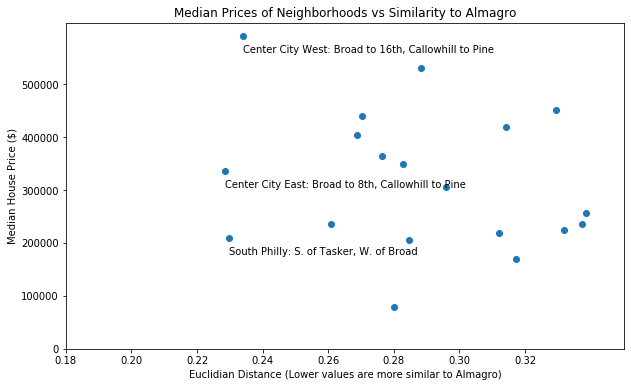

In [73]:
# Create scatter plot of median house price vs. similarity to Almagro, Madrid.
import matplotlib.pyplot as plt
x=df_phila.iloc[0:20,7]
y=df_phila.iloc[0:20,1]
plt.figure(figsize=(10, 6))
plt.scatter(x, y, marker='o')

plt.title('Median Prices of Neighborhoods vs Similarity to Almagro')
plt.yticks(np.arange(0, 600000, 100000))
plt.xticks(np.arange(.18, .32, 0.02))
plt.xlabel('Euclidian Distance (Lower values are more similar to Almagro)')
plt.ylabel('Median House Price ($)')
plt.text(df_phila.iloc[1,7],df_phila.iloc[1,1]-30000,df_phila.index[1])
plt.text(df_phila.iloc[2,7],df_phila.iloc[2,1]-30000,df_phila.index[2])
plt.text(df_phila.iloc[3,7],df_phila.iloc[3,1]-30000,df_phila.index[3])

plt.show()

**Observations:** Three neighborhoods stand out as being most similar to Almagro: (1) Center City East: Broad to 8th, Callowhill to Pine, (2) South Philly: S. of Tasker, W. of Broad and (3) Center City West: Broad to 16th, Callowhill to Pine.  Of these neighborhoods, South Philly is clearly the most affordable, with a median house price of $209,000.  			

## Conclusions

An effective algorithm has been developed for identifying neighborhoods in a selected city that are most similar to some desirable neighborhood in another city.  The algorithm utilizes k-means clustering to find groups of similar and dissimilar neighborhoods, and then identifies the most similar neighborhoods by calculating Euclidian distance from the target neighborhood in the multidimensional space.  Finally, the housing price statistics are incorporated in the analysis to identify neighborhoods that might be more affordable for the user, yet still relatively similar to the target neighborhood.

When applied for finding a neighborhood in the city of Philadelphia, Pennsylvania, USA that is most similar to Almagro in Madrid, Spain, three neighborhoods are identified as promising candidates: (1) Center City East: Broad to 8th, Callowhill to Pine, (2) South Philly: S. of Tasker, W. of Broad and (3) Center City West: Broad to 16th, Callowhill to Pine. Of these neighborhoods, South Philly is clearly the most affordable, with a median house price of $209,000.